## Homework
Implement object detection for Pascal VOC dataset. You can use pre-trained models from https://github.com/tensorflow/models. You are also allowed to use tf.slim and tf.contrib and free to use any architecture.

Split your data. Cross-validate your model on the test set and visualize some examples. Visualization quality is up to you.

In [1]:
import sys
sys.path.append('../tf_models/research/')
sys.path.append('../tf_models/research/slim/')
sys.path.append('../tf_models/research/object_detection/')

In [2]:
%matplotlib inline

import numpy as np
import skimage.io as io
import sys
from utils import label_map_util
from utils import visualization_utils as vis_util
import tensorflow as tf
import urllib, tarfile, xml
from PIL import Image
import os
import matplotlib.pyplot as plt

## Download Model

In [3]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = 'frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('../tf_models/research/object_detection/data/pascal_label_map.pbtxt')

NUM_CLASSES = 20

In [4]:
#opener = urllib.request.URLopener()
#opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
#tar_file = tarfile.open(MODEL_FILE)
#for file in tar_file.getmembers():
#  file_name = os.path.basename(file.name)
#  if 'frozen_inference_graph.pb' in file_name:
#    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory. 

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Parse annotations

In [7]:
class union:
    def __init__(self, label, ymin, xmin, ymax, xmax):
        self.label = label
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        
def get_annotation(filename):
    e = xml.etree.ElementTree.parse(filename).getroot()
    
    image_size = e.find('size')
    
    height = int(image_size.find('height').text)
    width = int(image_size.find('width').text)
    
    annotations = []
    
    for node in e.findall('object'):
        name = node.find('name').text
        bndbox = node.find('bndbox')
        xmin = float(bndbox.find('xmin').text) / width
        xmax = float(bndbox.find('xmax').text) / width
        ymin = float(bndbox.find('ymin').text) / height
        ymax = float(bndbox.find('ymax').text) / height
        
        annotations.append(union(name, ymin, xmin, ymax, xmax))
    
    return annotations

## VOC data

In [8]:
VOC_DIR = '../../pascal_data/VOCdevkit/VOC2012/'
IMAGE_DIR = os.path.join(VOC_DIR, 'JPEGImages')
ANNOT_DIR = os.path.join(VOC_DIR, 'Annotations')

def iterate_through_images(file_name):
    with open(file_name, 'r') as f:
        for i, name in enumerate(f):
            name = name.strip()
            image = Image.open(os.path.join(IMAGE_DIR, name + ".jpg"))
            image_np = load_image_into_numpy_array(image)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            annotation = get_annotation(os.path.join(ANNOT_DIR, name + ".xml"))
            yield i, image_np_expanded, annotation
            
NUMBER_OF_IMAGES = 5823
def iterate_to_draw(file_name):
    positions = np.random.choice(range(NUMBER_OF_IMAGES), size=5)
    cur_p = 0
    with open(file_name, 'r') as f:
        for i, name in enumerate(f):
            if i == positions[cur_p]:
                name = name.strip()
                image = Image.open(os.path.join(IMAGE_DIR, name + ".jpg"))
                image_np = load_image_into_numpy_array(image)
                annotation = get_annotation(os.path.join(ANNOT_DIR, name + ".xml"))
                yield i, image_np, annotation
                cur_p += 1
                if cur_p == 5:
                    break
    

## Calc IOU

In [9]:
IOU_THRESHOLD = 0.4

In [10]:
def area(box):
    return (box.xmax - box.xmin)*(box.ymax - box.ymin)

def intersection_area(box_1, box_2):
    dx = min(box_1.xmax, box_2.xmax) - max(box_1.xmin, box_2.xmin)
    dy = min(box_1.ymax, box_2.ymax) - max(box_1.ymin, box_2.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    return 0.0

def union_area(box_1, box_2):
    return area(box_1) + area(box_2) - intersection_area(box_1, box_2)

def get_iou_score(box_1, box_2):
    return intersection_area(box_1, box_2)/union_area(box_1, box_2)

## Calc score

In [11]:
def calc_score(found_boxes, labels, annotation):
    def find_best_fit_box_score(annot_box):
        found_flag = False
        max_iou_score = 0
        for box, label in zip(found_boxes, labels):
            box_union = union(category_index[label]['name'], *box)
            if box_union.label == annot_box.label:
                iou_score = get_iou_score(box_union, annot_box)
                max_iou_score = max(max_iou_score, iou_score)
                found_flag = True
        return found_flag, max_iou_score
    
    result_found = 0
    result_iou_scores_list = []
    for annot_box in annotation:
        flag, iou = find_best_fit_box_score(annot_box)
        if flag and iou > IOU_THRESHOLD:
            result_found += 1
            result_iou_scores_list.append(iou)
    presition = 1.*result_found/len(annotation)
    return presition, np.mean(np.array(result_iou_scores_list))

## Test model and print accuracy

In [12]:
#train_path = os.path.join(VOC_DIR, 'ImageSets', 'Main', 'train.txt')
test_path = os.path.join(VOC_DIR, 'ImageSets', 'Main', 'val.txt')

In [13]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [14]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)
SCORE_THRESHOLD = 0.5

acc_scores = []
iou_scores = []

with tf.Session(graph=detection_graph, config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for i, image_np_expanded, annotation in iterate_through_images(test_path):
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            
            good = scores[0] > SCORE_THRESHOLD
            acc, iou = calc_score(boxes[0][good], classes[0][good], annotation)

            acc_scores.append(acc)
            if iou > 0:
                iou_scores.append(iou)
            
            if i % 10 == 0:
                print('Processed: {:5d}\tAccuracy: {:.3f}\t\tMean IoU score: {:.3f}'.format(i+1, np.mean(acc_scores),
                                                                        np.mean(iou_scores)))

Processed:     1	Accuracy: 1.000		Mean IoU score: 0.841


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processed:    11	Accuracy: 0.773		Mean IoU score: 0.869
Processed:    21	Accuracy: 0.832		Mean IoU score: 0.843
Processed:    31	Accuracy: 0.796		Mean IoU score: 0.844
Processed:    41	Accuracy: 0.809		Mean IoU score: 0.832
Processed:    51	Accuracy: 0.818		Mean IoU score: 0.822
Processed:    61	Accuracy: 0.848		Mean IoU score: 0.826
Processed:    71	Accuracy: 0.856		Mean IoU score: 0.820
Processed:    81	Accuracy: 0.852		Mean IoU score: 0.818
Processed:    91	Accuracy: 0.855		Mean IoU score: 0.818
Processed:   101	Accuracy: 0.863		Mean IoU score: 0.818
Processed:   111	Accuracy: 0.864		Mean IoU score: 0.817
Processed:   121	Accuracy: 0.855		Mean IoU score: 0.817
Processed:   131	Accuracy: 0.864		Mean IoU score: 0.811
Processed:   141	Accuracy: 0.873		Mean IoU score: 0.814
Processed:   151	Accuracy: 0.874		Mean IoU score: 0.816
Processed:   161	Accuracy: 0.873		Mean IoU score: 0.820
Processed:   171	Accuracy: 0.878		Mean IoU score: 0.819
Processed:   181	Accuracy: 0.875		Mean IoU score

Processed:  1481	Accuracy: 0.850		Mean IoU score: 0.821
Processed:  1491	Accuracy: 0.850		Mean IoU score: 0.821
Processed:  1501	Accuracy: 0.850		Mean IoU score: 0.821
Processed:  1511	Accuracy: 0.851		Mean IoU score: 0.821
Processed:  1521	Accuracy: 0.850		Mean IoU score: 0.821
Processed:  1531	Accuracy: 0.849		Mean IoU score: 0.821
Processed:  1541	Accuracy: 0.849		Mean IoU score: 0.821
Processed:  1551	Accuracy: 0.848		Mean IoU score: 0.821
Processed:  1561	Accuracy: 0.849		Mean IoU score: 0.821
Processed:  1571	Accuracy: 0.849		Mean IoU score: 0.821
Processed:  1581	Accuracy: 0.849		Mean IoU score: 0.821
Processed:  1591	Accuracy: 0.849		Mean IoU score: 0.821
Processed:  1601	Accuracy: 0.849		Mean IoU score: 0.821
Processed:  1611	Accuracy: 0.849		Mean IoU score: 0.821
Processed:  1621	Accuracy: 0.849		Mean IoU score: 0.821
Processed:  1631	Accuracy: 0.849		Mean IoU score: 0.821
Processed:  1641	Accuracy: 0.848		Mean IoU score: 0.821
Processed:  1651	Accuracy: 0.849		Mean IoU score

Processed:  2951	Accuracy: 0.844		Mean IoU score: 0.820
Processed:  2961	Accuracy: 0.843		Mean IoU score: 0.820
Processed:  2971	Accuracy: 0.843		Mean IoU score: 0.819
Processed:  2981	Accuracy: 0.843		Mean IoU score: 0.819
Processed:  2991	Accuracy: 0.843		Mean IoU score: 0.819
Processed:  3001	Accuracy: 0.843		Mean IoU score: 0.820
Processed:  3011	Accuracy: 0.843		Mean IoU score: 0.820
Processed:  3021	Accuracy: 0.843		Mean IoU score: 0.820
Processed:  3031	Accuracy: 0.844		Mean IoU score: 0.820
Processed:  3041	Accuracy: 0.844		Mean IoU score: 0.820
Processed:  3051	Accuracy: 0.844		Mean IoU score: 0.820
Processed:  3061	Accuracy: 0.844		Mean IoU score: 0.820
Processed:  3071	Accuracy: 0.844		Mean IoU score: 0.820
Processed:  3081	Accuracy: 0.844		Mean IoU score: 0.820
Processed:  3091	Accuracy: 0.844		Mean IoU score: 0.820
Processed:  3101	Accuracy: 0.844		Mean IoU score: 0.820
Processed:  3111	Accuracy: 0.844		Mean IoU score: 0.820
Processed:  3121	Accuracy: 0.844		Mean IoU score

Processed:  4421	Accuracy: 0.841		Mean IoU score: 0.820
Processed:  4431	Accuracy: 0.841		Mean IoU score: 0.820
Processed:  4441	Accuracy: 0.841		Mean IoU score: 0.820
Processed:  4451	Accuracy: 0.841		Mean IoU score: 0.820
Processed:  4461	Accuracy: 0.841		Mean IoU score: 0.820
Processed:  4471	Accuracy: 0.841		Mean IoU score: 0.820
Processed:  4481	Accuracy: 0.841		Mean IoU score: 0.820
Processed:  4491	Accuracy: 0.841		Mean IoU score: 0.820
Processed:  4501	Accuracy: 0.841		Mean IoU score: 0.820
Processed:  4511	Accuracy: 0.841		Mean IoU score: 0.820
Processed:  4521	Accuracy: 0.841		Mean IoU score: 0.820
Processed:  4531	Accuracy: 0.842		Mean IoU score: 0.820
Processed:  4541	Accuracy: 0.842		Mean IoU score: 0.820
Processed:  4551	Accuracy: 0.842		Mean IoU score: 0.820
Processed:  4561	Accuracy: 0.842		Mean IoU score: 0.820
Processed:  4571	Accuracy: 0.842		Mean IoU score: 0.820
Processed:  4581	Accuracy: 0.842		Mean IoU score: 0.820
Processed:  4591	Accuracy: 0.842		Mean IoU score

In [16]:
print('Processed: {:5d} images\nFinal accuracy: {:.3f}\t\tFinal mean IoU score: {:.3f}'.format(i+1, np.mean(acc_scores),
                                                                        np.mean(iou_scores)))

Processed:  5823 images
Final accuracy: 0.833		Final mean IoU score: 0.819


[ 825 3091 4370 2295 1379]


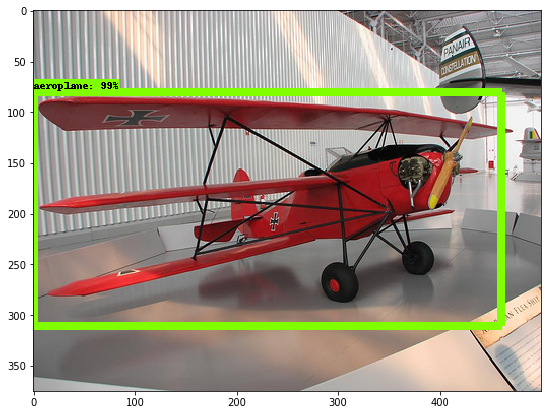

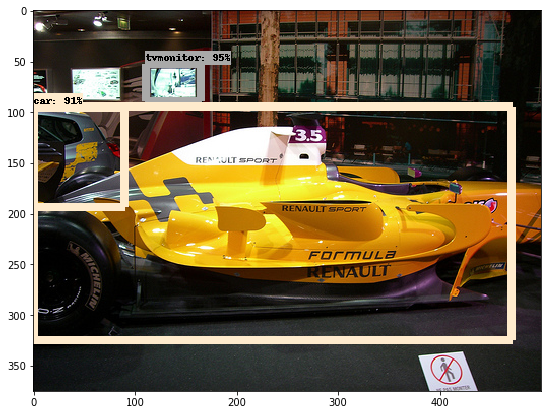

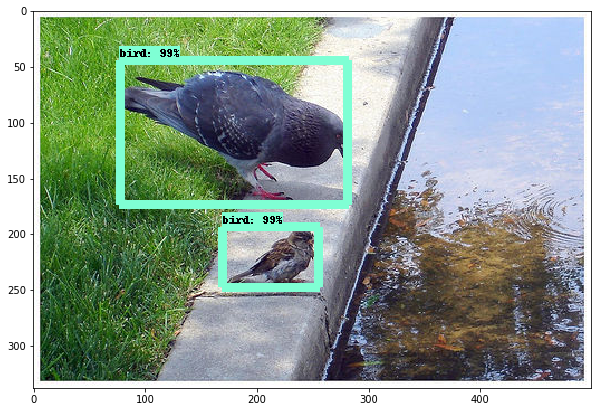

In [29]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for i, image_np, annotation in iterate_to_draw(test_path):
            image_np_expanded = np.expand_dims(image_np, axis=0)
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=8)
            plt.figure(figsize=(10, 7))
            plt.imshow(image_np)
        
